In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy.stats import multivariate_normal
from scipy.sparse import linalg
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm.notebook import tqdm, trange
import time # to be used in loop iterations
np.random.seed(1234)

## Single-digit neural single layer network trained on the MNIST dataset

I implemented a neural single layer network with symmetric architecture trained on the MNIST dataset that performs single digit architecture and tried to study the asymptotic distribution of network parameters as claimed in the 2019 paper by Sirgiano and Spiliopoulos entitled 'Mean Field Analysis of Neural Networks: A Law of Large Numbers'.

In [2]:
def sigmoid(x):
    if x < 0:
        return np.exp(x)/(1+np.exp(x))
    else:
        return 1/(1+np.exp(-x))
vsigmoid = np.vectorize(sigmoid)   

In [3]:
#standardising dataset
def standardise_mlp(X):
    """
    Args:

    X: numpy array of shape (n_samples, n_features) representing the input data

    Returns:

    Xbar: numpy array of shape (n_samples, n_features) representing the standardized input data
    """
    mu = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    std_filled = std.copy()
    std_filled[std==0] = 1.
    Xstd = ((X-mu)/std_filled)
    return Xstd

In [6]:
# Load training data 

#train data
data = pd.read_csv('MNIST_train.csv')

#training set ground truth labels
y_train = np.squeeze(np.array(data[data.columns[0]]))

train_data = data[data.columns[1:]].to_numpy()

#standardise train data
train_data_std = standardise_mlp(train_data)

#test data
test_data = pd.read_csv('MNIST_test.csv')

#test set ground truth labels
y_test = np.array(test_data[test_data.columns[0]])

test_data = test_data[test_data.columns[1:]].to_numpy()

#standardise test data
test_data_std = standardise_mlp(test_data)


x_train = train_data_std
y_train = np.where(y_train == 0,  1, -1)
x_test = test_data_std
y_test = np.where(y_test == 0,  1, -1)

In [7]:
def neural_net(x,w,c):
    """
    Compute the output of a neural network with given weights and coefficients.

    Parameters:
    x (np.ndarray): Input data with shape (n, d).
    w (np.ndarray): Weight matrix with shape (N, d).
    c (np.ndarray): Coefficients of the neural network with shape (1, N).

    Returns:
    np.ndarray: The output of the neural network with shape (1, n).
    """
    n = x.shape[0]
    d = x.shape[1]
    N = w.shape[0]
    return (1/N*c@vsigmoid(w@x.T)).reshape(1,n)

In [64]:
def train(x_train, y_train, x_test, y_test, N = 100, learning_rate = 1e-2):
    """
    Train a neural network with a specified number of units (N) using stochastic gradient descent.

    Parameters:
    x_train (np.ndarray): Training input data with shape (M, d).
    y_train (np.ndarray): Training target data with shape (M, 1).
    x_test (np.ndarray): Testing input data with shape (M_test, d).
    y_test (np.ndarray): Testing target data with shape (M_test, 1).
    N (int): The number of neural network units (default is 100).
    learning_rate (float): The learning rate for stochastic gradient descent (default is 1e-2).

    Returns:
    tuple: A tuple containing the trained coefficients 'c' and weights 'w', flattened coefficients 'c_flat',
           and a list of loss values during training.
    """
    losses = []
    #Initialise Params
    M,d = x_train.shape
    var_w = 6. / (d+N)
    var_c = 6./ (10+N)
    w =  np.random.multivariate_normal([0]*d, np.diag([np.sqrt(var_w)]*d), N).reshape(N,d)
    c =  np.random.uniform(-1000, 1000, (1,N))
    
    #sgd - update weights (using KL loss)
    count = 1
    
    for x,y in tqdm(zip(x_train,y_train)):
        y = y.reshape(1,-1)
        x = x.reshape(1,-1)
        f = neural_net(x,w,c).reshape(1,-1)
        s = vsigmoid(w@x.T)
        dw = 1/N * ((f-y)@c).T*(s*(1-s))*x
        dc = 1/N * (f-y).T*s.reshape(1,-1)
        w -= learning_rate*dw
        c -= learning_rate*dc
        
        if  count in [1, 10 , 100] + list((10**np.linspace(3, 4.7, 20)).astype(int)): 
            f_test = neural_net(x_test,w,c).reshape(-1,1)
            y_test = y_test.reshape(-1,1)
            loss = 0.5*np.mean((f_test-y_test)**2)
            print('Epoch count: {}, Loss: {}'.format(count, loss))
            losses.append(loss)
        
        count += 1 
        
    return c, w, np.ndarray.flatten(c), losses

In [109]:
def nesterov_train(x_train, y_train, x_test, y_test, N = 100, r = 3, learning_rate = 1e-2):
    """
    Train a neural network with a specified number of units (N) using Nesterov's accelerated gradient descent.

    Parameters:
    x_train (np.ndarray): Training input data with shape (M, d).
    y_train (np.ndarray): Training target data with shape (M, 1).
    x_test (np.ndarray): Testing input data with shape (M_test, d).
    y_test (np.ndarray): Testing target data with shape (M_test, 1).
    N (int): The number of neural network units (default is 100).
    r (int): The number of steps for Nesterov's acceleration (default is 3).
    learning_rate (float): The learning rate for Nesterov's SGD (default is 1e-2).

    Returns:
    tuple: A tuple containing the trained coefficients 'c' and weights 'w', flattened coefficients 'c_flat',
           and a list of loss values during training.
    """
    losses = []
    #Initialise Params
    M,d = x_train.shape
    var_w = 6. / (d+N)
    var_c = 6./ (10+N)
    w =  np.random.multivariate_normal([0]*d, np.diag([np.sqrt(var_w)]*d), N).reshape(N,d)
    c =  np.random.uniform(-1000, 1000, (1,N))
    w_change = w
    c_change = c
    
    count = 1
    
    for x,y in tqdm(zip(x_train,y_train)):
        y = y.reshape(1,-1)
        x = x.reshape(1,-1)
        f = neural_net(x,w_change,c_change).reshape(1,-1)
        s = vsigmoid(w_change@x.T)
        dw = 1/N * ((f-y)@c_change).T*(s*(1-s))*x
        dc = 1/N * (f-y).T*s.reshape(1,-1)
        w1 = w
        c1 = c
        
        if  count in [1, 10 , 100] + list((10**np.linspace(3, 4.7, 20)).astype(int)): 
            f_test = neural_net(x_test,w,c).reshape(-1,1)
            y_test = y_test.reshape(-1,1)
            loss = 0.5*np.mean((f_test-y_test)**2)
            print('Epoch count: {}, Loss: {}'.format(count, loss))
            losses.append(loss)
         
        
        w_new = w_change - learning_rate*dw
        c_new = c_change - learning_rate*dc
        w_change = w_new + 0.9*(w_new-w1) 
        c_change = c_new + 0.9*(c_new-c1) 
        w = w_new
        c = c_new
        
        count += 1
        
    return c, w, np.ndarray.flatten(c), losses

In [207]:
def Hom_SGLD(x_train, y_train, x_test, y_test, N = 100,  M = 20, λ = 10, learning_rate = 1e-3):
    """
    Train a neural network with a specified number of units (N) using Hamiltonian SGLD (Hom-SGLD).

    Parameters:
    x_train (np.ndarray): Training input data with shape (M, d).
    y_train (np.ndarray): Training target data with shape (M, 1).
    x_test (np.ndarray): Testing input data with shape (M_test, d).
    y_test (np.ndarray): Testing target data with shape (M_test, 1).
    N (int): The number of neural network units (default is 100).
    M (int): The number of Hamiltonian SGLD steps (default is 20).
    λ (float): The regularization parameter (default is 10).
    learning_rate (float): The learning rate for Hom-SGLD (default is 1e-3).

    Returns:
    tuple: A tuple containing the trained coefficients 'c' and weights 'w', flattened coefficients 'c_flat',
           and an array of loss values during training.
    """

    #initialise Params
    d = x_train.shape[1]
    var_w = 6. / (d+N)
    var_c = 6./ (10+N)
    w =  np.random.multivariate_normal([0]*d, np.diag([np.sqrt(var_w)]*d), N).reshape(N,d)
    c =  np.random.uniform(-1000, 1000, (1,N))
    
    #initialise fast time scale variables Y as a numpy matrix with dimensions (num_epochs, N, M)
    Y_w = np.zeros((M+1, N, d))
    Y_c = np.zeros((M+1, N))
    
    losses = []
    
    count = 1
    
    for x,y in tqdm(zip(x_train,y_train)):
        y = y.reshape(1,-1)
        x = x.reshape(1,-1)

        #update Y
        Y_w_1 = np.zeros((M+1, N, d))
        Y_c_1 = np.zeros((M+1, N))
        Y_w_1[0, :, :] = Y_w[-1, :, :] 
        Y_c_1[0, :] = Y_c[-1, :]

        for m in range(1,M+1):
            δ = 0.01/20
            γ = 0.1
            β = 10
            f = neural_net(x, Y_w_1[m-1, :, :].reshape((N,d)),  Y_c_1[m-1, :].reshape((1,N)))
            s = vsigmoid(Y_w_1[m-1, :, :].reshape((N,d))@x.T)
            dw = 1/N * ((f-y)@Y_c_1[m-1,:].reshape(1,N)).T*(s*(1-s))*x
            dc = 1/N * (f-y).T*s.reshape(1,-1)

            Y_w_1[m, :,:] = Y_w_1[m-1, : ,:] - δ*(dw-(1/γ)*(w-Y_w_1[m-1, :, :]))\
            + np.sqrt(2*(δ/β))*np.random.normal(0,1,(N,d))
            Y_c_1[m, :] = Y_c_1[m-1,:] - δ*(dc-(1/γ)*(c-Y_c_1[m-1, :]))\
            + np.sqrt(2*(δ/β))*np.random.normal(0,1,N)

        Y_w[0, :, :] = Y_w_1[-1, :, :]
        Y_c[0, :] = Y_c_1[-1, :]


        cal_Y_w = np.mean(Y_w_1, axis = 0)
        cal_Y_c = np.mean(Y_c_1, axis = 0)


        #update model parameters
        Δ = learning_rate
        X = np.hstack((w, c.T))
        mu = np.mean(X, axis = 1).reshape(1,N)
        w = w - 1/γ*(w-cal_Y_w)*Δ - λ*(w - mu.T)*Δ
        c = c - 1/γ*(c-cal_Y_c)*Δ - λ*(c - mu)*Δ

        if  count in [1, 10, 50, 100, 200, 300, 500, 700, 900] + list((10**np.linspace(3, 4.7, 20)).astype(int)): 
            f_test = neural_net(x_test,w,c).reshape(-1,1)
            y_test = y_test.reshape(-1,1)
            loss = 0.5*np.mean((f_test-y_test)**2)
            print('Epoch count: {}, Loss: {}'.format(count, loss))
            losses.append(loss)

        count+=1
                
    return c, w, np.ndarray.flatten(c), np.array(losses)

In [198]:
def Mass(x_train, y_train, x_test, y_test, N = 100,  M = 20, λ = 10, learning_rate = 1e-3):
    """
    Train a neural network with a specified number of units (N) using Momentum-added Stochastic Solver (Mass).

    Parameters:
    x_train (np.ndarray): Training input data with shape (M, d).
    y_train (np.ndarray): Training target data with shape (M, 1).
    x_test (np.ndarray): Testing input data with shape (M_test, d).
    y_test (np.ndarray): Testing target data with shape (M_test, 1).
    N (int): The number of neural network units (default is 100).
    M (int): The number of Mass steps (default is 20).
    λ (float): The regularization parameter (default is 10).
    learning_rate (float): The learning rate for Mass (default is 1e-3).

    Returns:
    tuple: A tuple containing the trained coefficients 'c' and weights 'w',
           and an array of loss values during training.
    """

    losses = []
    #Initialise Params
    M,d = x_train.shape
    var_w = 6. / (d+N)
    var_c = 6./ (10+N)
    w =  np.random.multivariate_normal([0]*d, np.diag([np.sqrt(var_w)]*d), N).reshape(N,d)
    c =  np.random.uniform(-1000, 1000, (1,N))
    w_change = w
    c_change = c
    
    count = 1
    
    for x,y in tqdm(zip(x_train,y_train)):
        y = y.reshape(1,-1)
        x = x.reshape(1,-1)
        f = neural_net(x,w_change,c_change).reshape(1,-1)
        s = vsigmoid(w_change@x.T)
        dw = 1/N * ((f-y)@c_change).T*(s*(1-s))*x
        dc = 1/N * (f-y).T*s.reshape(1,-1)
        w1 = w
        c1 = c
        
        alpha = 0.05
        m = 2
        eta2 = learning_rate/(1+alpha)/m
        
        w_new = w_change - learning_rate*dw
        c_new = c_change - learning_rate*dc
        w_change = w_new + 0.9*(w_new-w1) - eta2*dw
        c_change = c_new + 0.9*(c_new-c1) - eta2*dc
        w = w_new
        c = c_new
        
        if  count in [1, 10, 100] + list((10**np.linspace(3, 4.5, 20)).astype(int)): 
            f_test = neural_net(x_test,w,c).reshape(-1,1)
            y_test = y_test.reshape(-1,1)
            loss = 0.5*np.mean((f_test-y_test)**2)
            print('Epoch count: {}, Loss: {}'.format(count, loss))
            losses.append(loss)

        count+=1
                
    return c, w, np.array(losses)

In [199]:
c, w, risk_Mass = Mass(x_train, y_train, x_test, y_test, N = 100, learning_rate = 1e-3)

0it [00:00, ?it/s]

Epoch count: 1, Loss: 392.22603228792167
Epoch count: 10, Loss: 4406.230405569741
Epoch count: 100, Loss: 546.7861561579771
Epoch count: 1000, Loss: 167.09376341245323
Epoch count: 1199, Loss: 170.03827644389358
Epoch count: 1438, Loss: 159.45724137212554
Epoch count: 1725, Loss: 145.43328051901256
Epoch count: 2069, Loss: 141.77374660203455
Epoch count: 2481, Loss: 141.8105222643557
Epoch count: 2976, Loss: 128.39877980481157
Epoch count: 3569, Loss: 125.1981958670059
Epoch count: 4281, Loss: 120.95670491943278
Epoch count: 5134, Loss: 117.92977042152896
Epoch count: 6158, Loss: 120.73053616413841
Epoch count: 7386, Loss: 110.62481165751461
Epoch count: 8858, Loss: 102.08336019878887
Epoch count: 10624, Loss: 105.45266005117381
Epoch count: 12742, Loss: 103.07184722994285
Epoch count: 15283, Loss: 101.34570092596189
Epoch count: 18329, Loss: 103.40556529120413
Epoch count: 21983, Loss: 96.97226615801434
Epoch count: 26366, Loss: 96.15335732278938
Epoch count: 31622, Loss: 96.068815936

In [210]:
#simulate HomSGLD

c_HomSGLD, weights_HomSGLD, params_HomSGLD, risk_HomSGLD,  =\
Hom_SGLD(x_train, y_train, x_test, y_test, N = 200, learning_rate = 1e-3)

0it [00:00, ?it/s]

Epoch count: 1, Loss: 622.9722535023558
Epoch count: 10, Loss: 9556.628981234095
Epoch count: 50, Loss: 3789.6050676411232
Epoch count: 100, Loss: 556.815974590345
Epoch count: 200, Loss: 9.878454071931195
Epoch count: 300, Loss: 0.5571957047257495
Epoch count: 500, Loss: 0.49962111878074056
Epoch count: 700, Loss: 0.4999803784135141
Epoch count: 900, Loss: 0.4999972007125415
Epoch count: 1000, Loss: 0.49999334090677117
Epoch count: 1228, Loss: 0.5000296801125511
Epoch count: 1509, Loss: 0.5000481327866183
Epoch count: 1855, Loss: 0.5000071376307691
Epoch count: 2279, Loss: 0.4999817300362109
Epoch count: 2801, Loss: 0.4999934046143166
Epoch count: 3442, Loss: 0.49998606561813014
Epoch count: 4229, Loss: 0.4999579359687284
Epoch count: 5197, Loss: 0.5000019570999912
Epoch count: 6386, Loss: 0.5000082132609088
Epoch count: 7847, Loss: 0.4999992069205719
Epoch count: 9642, Loss: 0.5000030304559553
Epoch count: 11849, Loss: 0.49993541412164
Epoch count: 14559, Loss: 0.49999586508665433
Ep

In [187]:
c, w, params, risk_SGD = train(x_train, y_train, x_test, y_test, N = 100, learning_rate = 1e-3)

0it [00:00, ?it/s]

Epoch count: 1, Loss: 1375.748244523452
Epoch count: 10, Loss: 1991.975920023121
Epoch count: 100, Loss: 838.1252173346121
Epoch count: 1000, Loss: 243.82441409740775
Epoch count: 1228, Loss: 233.6584786585303
Epoch count: 1509, Loss: 192.66583811663165
Epoch count: 1855, Loss: 167.77158615896587
Epoch count: 2279, Loss: 157.56736683720953
Epoch count: 2801, Loss: 148.53302474349184
Epoch count: 3442, Loss: 128.11190035681383
Epoch count: 4229, Loss: 118.90360894481204
Epoch count: 5197, Loss: 114.7107754376242
Epoch count: 6386, Loss: 103.77031746072726
Epoch count: 7847, Loss: 103.53498055331077
Epoch count: 9642, Loss: 92.6854179984925
Epoch count: 11849, Loss: 90.56921996634574
Epoch count: 14559, Loss: 85.17131246015782
Epoch count: 17890, Loss: 81.92649904364225
Epoch count: 21983, Loss: 78.34374385032342
Epoch count: 27013, Loss: 75.603159850877
Epoch count: 33193, Loss: 70.82584165782184
Epoch count: 40787, Loss: 69.16086256448652
Epoch count: 50118, Loss: 64.14294125641159


In [188]:
c, w, params_NSGD, risk_NSGD = nesterov_train(x_train, y_train, x_test, y_test, N = 100, learning_rate = 1e-3)

0it [00:00, ?it/s]

Epoch count: 1, Loss: 406.3524977166169
Epoch count: 10, Loss: 2443.047987379032
Epoch count: 100, Loss: 634.4378476333052
Epoch count: 1000, Loss: 171.67665197292018
Epoch count: 1228, Loss: 163.12415241336424
Epoch count: 1509, Loss: 149.12713581931064
Epoch count: 1855, Loss: 141.02671428168262
Epoch count: 2279, Loss: 139.19011191733588
Epoch count: 2801, Loss: 125.90457010430005
Epoch count: 3442, Loss: 118.70078769376069
Epoch count: 4229, Loss: 112.38738414762618
Epoch count: 5197, Loss: 120.54052688575334
Epoch count: 6386, Loss: 116.50069993960591
Epoch count: 7847, Loss: 113.15885304549546
Epoch count: 9642, Loss: 111.35470541017787
Epoch count: 11849, Loss: 110.1170930131302
Epoch count: 14559, Loss: 105.90591369772869
Epoch count: 17890, Loss: 105.80806764168898
Epoch count: 21983, Loss: 102.25099406783748
Epoch count: 27013, Loss: 102.75523302037114
Epoch count: 33193, Loss: 99.91470289759063
Epoch count: 40787, Loss: 96.4752989120979
Epoch count: 50118, Loss: 95.345464776

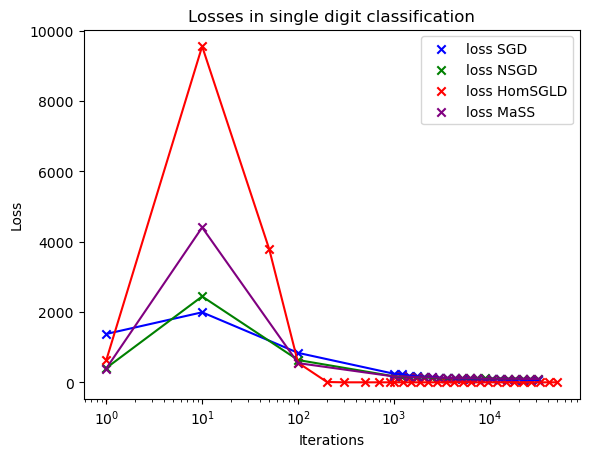

In [211]:
#plot SGD losses vs Nesterov accelerated SGD losses
indices = [1, 10 , 100] + list((10**np.linspace(3, 4.5, 20)).astype(int))
indices_hom = [1, 10, 50, 100, 200, 300, 500, 700, 900] + list((10**np.linspace(3, 4.7, 20)).astype(int))
fig, ax = plt.subplots()
ax.plot(indices, risk_SGD, c = 'b')
ax.plot(indices, risk_NSGD, c = 'g')
ax.plot(indices_hom, risk_HomSGLD, c = 'r')
ax.plot(indices, risk_Mass, c = 'purple')
ax.scatter(indices, risk_SGD, marker = 'x', c = 'b', label = 'loss SGD')
ax.scatter(indices, risk_NSGD, marker = 'x', c = 'g', label = 'loss NSGD')
ax.scatter(indices_hom, risk_HomSGLD, marker = 'x', c = 'r', label = 'loss HomSGLD')
ax.scatter(indices, risk_Mass, marker = 'x', c = 'purple', label = 'loss MaSS')


ax.set_xscale('log')
ax.set_xlabel('Iterations')
ax.set_ylabel('Loss')
ax.set_title('Losses in single digit classification')
ax.legend()
plt.show()

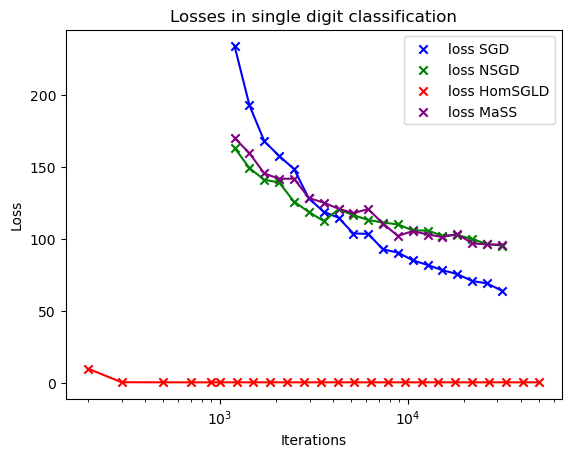

In [213]:
#plot SGD losses vs Nesterov accelerated SGD losses
indices = [1, 10 , 100] + list((10**np.linspace(3, 4.5, 20)).astype(int))
indices_hom = [1, 10, 50, 100, 200, 300, 500, 700, 900] + list((10**np.linspace(3, 4.7, 20)).astype(int))
fig, ax = plt.subplots()
ax.plot(indices[4:], risk_SGD[4:], c = 'b')
ax.plot(indices[4:], risk_NSGD[4:], c = 'g')
ax.plot(indices_hom[4:], risk_HomSGLD[4:], c = 'r')
ax.plot(indices[4:], risk_Mass[4:], c = 'purple')
ax.scatter(indices[4:], risk_SGD[4:], marker = 'x', c = 'b', label = 'loss SGD')
ax.scatter(indices[4:], risk_NSGD[4:], marker = 'x', c = 'g', label = 'loss NSGD')
ax.scatter(indices_hom[4:], risk_HomSGLD[4:], marker = 'x', c = 'r', label = 'loss HomSGLD')
ax.scatter(indices[4:], risk_Mass[4:], marker = 'x', c = 'purple', label = 'loss MaSS')


ax.set_xscale('log')
ax.set_xlabel('Iterations')
ax.set_ylabel('Loss')
ax.set_title('Losses in single digit classification')
ax.legend()
plt.show()

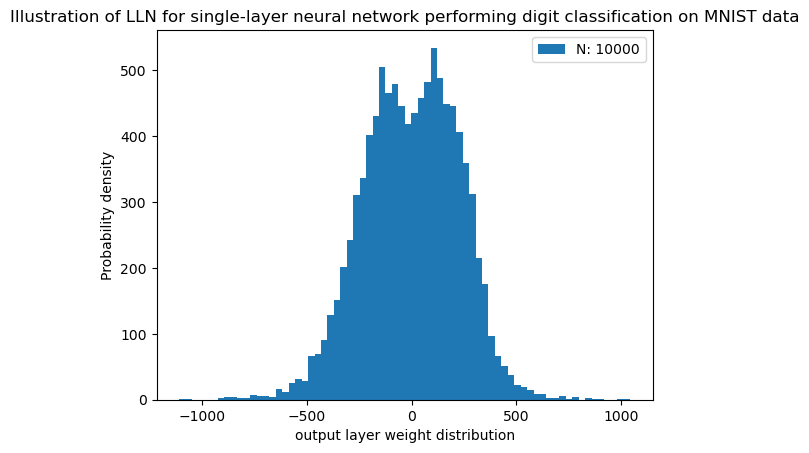

In [43]:
plt.hist(params, label = 'N: 10000', bins = 70)
plt.title('Illustration of LLN for single-layer neural network performing digit classification on MNIST data')
plt.ylabel('Probability density')
plt.xlabel('output layer weight distribution')
plt.legend()

## General Observations

- Nesterov acceleration beat plain SGD, but was beaten by MF-HomSGLD, which plateaued early but achieved a substantially smaller loss in the same amount of time
- MF-HomSGLD (in the paper by Pavliotis, Kantas and Parpas entitled 'The sharp, the flat and the shallow: Can weakly interacting agents learn to escape bad minima?') matches the performance of plain SGD. Still, it gets stuck for more significant iterations and plateaus. However, in the MNIST one-digit classification, the algorithm attains a substantially smaller loss, about two orders of magnitude less than the other algorithms. However, it suffers from plateauing early again.
- Finally, the single-digit classifier with the architecture satisfied the assumptions made in the paper. It was able to reproduce the distribution of parameters in the paper, as seen in the plot above, capturing the bimodality of the network parameter distribution in the paper.